# libs

In [1]:
#!pip install jdatetime

In [16]:
import time
import math
import numpy as np
import random
import itertools
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import jdatetime
from typing import List

# variables

In [2]:
max_raas_days = 65
max_discount_percentage = 20 / 100 # 20%

max_price_change = 3
number_of_generated_pricess = 100

# discount

In [3]:
def get_discount(raas_day):
    if raas_day < 5:
        return 20
    if raas_day < 10:
        return 19.5
    if raas_day < 15:
        return 19
    if raas_day < 20:
        return 18.25
    if raas_day < 25:
        return 17.5
    if raas_day < 30:
        return 16.25
    if raas_day < 35:
        return 15
    if raas_day < 40:
        return 13.5
    if raas_day < 45:
        return 12
    if raas_day < 50:
        return 10
    if raas_day < 55:
        return 8
    if raas_day < 60:
        return 5.5
    if raas_day < 65:
        return 3
    if raas_day < 70:
        return 0        
    return get_discount(65 - (raas_day - 65))

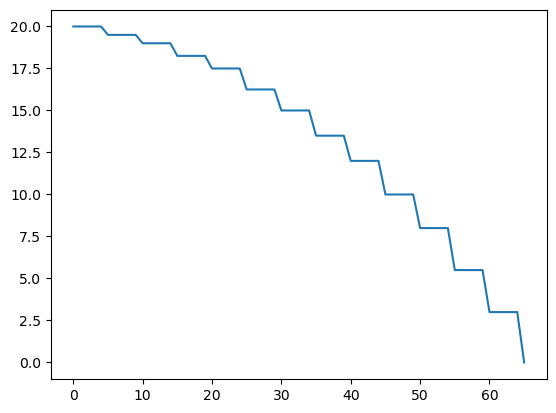

In [4]:
index = [i for i in range(0, 66)]
value =[get_discount(i) for i in index]
plt.plot(index, value)
plt.show()

# functions

In [5]:
def disp(plan):    
    print("raas_days", plan['raas_days'])
    print("discount", str(plan['discount'] * 100) + "%")
    for check in plan['checks']:
        formatted_date = check[0].strftime("%Y,%m,%d")        
        print((formatted_date, check[1]))

In [6]:
def get_raas_days(total_amount, cash_amount, check_payments):    
    weighted_sum = 0
    for days, amount in check_payments:
        weighted_sum += days * amount
    raas_days = weighted_sum / total_amount
    return round(raas_days)

In [7]:
def generate_check_combinations(check_number, duration_days):
    # Generate combinations of check distributions using only acceptable periods
    combinations = []
    for combo in itertools.product(acceptable_periods, repeat=check_number):
        if sum(combo) <= duration_days:            
            periods = [sum(combo[:i]) for i in range(check_number+1)]            
            combinations.append(periods[1:])    
    print(len(combinations))
    return combinations

In [8]:
def get_date(start_date, number_of_months):
    start_shift_days = 20
    acceptable_days = [5, 10, 15, 20, 25, 30]    
    dates = []
    current_date = start_date
    first_check_date = start_date + jdatetime.timedelta(days=start_shift_days)

    
    for _ in range(number_of_months):
        year = current_date.year
        month = current_date.month
        
        for day in acceptable_days:
            try:
                temp  = jdatetime.date(year, month, day)
                if temp < first_check_date:
                    continue
                dates.append(temp)
            except ValueError:                
                continue
        
        # Move to the next month
        if month == 12:
            current_date = jdatetime.date(year + 1, 1, 1)
        else:
            current_date = jdatetime.date(year, month + 1, 1)
    
    return dates

In [9]:
def get_plans(dates, start_date, number_of_checks, number_of_months):
    plans = []
    max_depth = len(dates)
    def get_selected_dates(ans, index=0, in_month_check=0, total_checkd=0):                
        if total_checkd == number_of_checks:
            plans.append(ans)            
        
        elif index >= max_depth:
            return 
        
        elif in_month_check == 0:            
            # for selection
            temp_ans = ans.copy()
            temp_ans[index] = 1                        
            if(index+2 < max_depth and dates[index].month == dates[index+2].month):
                in_month_check = 1                                    
            get_selected_dates(temp_ans, index + 2, in_month_check, total_checkd+1)
            # for not selection
            temp_ans = ans.copy()
            get_selected_dates(temp_ans, index + 1, 0, total_checkd)                        
            
        elif in_month_check == 1:            
            # for selection
            temp_ans = ans.copy()
            temp_ans[index] = 1  
            counter = 0
            for i in range(index+1, max_depth):
                if(dates[index].month != dates[i].month):
                    break
                counter += 1                                                                           
            counter = max(counter, 2)
            get_selected_dates(temp_ans, index + counter, 0, total_checkd+1)
            # for not selection
            temp_ans = ans.copy()
            if(index+1 < max_depth and dates[index].month != dates[index+1].month):
                in_month_check = 0
            get_selected_dates(temp_ans, index + 1, in_month_check, total_checkd)
                                             
    ans = np.zeros(max_depth, int)
    get_selected_dates(ans.copy())
    return plans

In [10]:
def generate_price_variations(prices, m, num_variations):
    def adjust_prices(prices, m):
        new_prices = prices.copy()
        for i in range(len(new_prices)):
            change = random.randint(-m, m)
            new_prices[i] += change            
            new_prices[i] = max(new_prices[i], 0)
        # Adjust to make sure the sum remains the same
        total_change = sum(new_prices) - sum(prices)
        if total_change != 0:
            adjust_index = random.randint(0, len(new_prices) - 1)
            new_prices[adjust_index] -= total_change
            # Ensure price doesn't go below 0
            new_prices[adjust_index] = max(new_prices[adjust_index], 0)
        return new_prices

    variations = {}
    for _ in range(num_variations):
        v = adjust_prices(prices, m)
        if 0 in v:
            continue
        variations[str(v)] = v        
    return list(variations.values())

In [14]:
plans = None
pricess = None
duration = None
dates = None
non_zero = None
raas_days= None

def suggest_payment_plans(start_date, total, cash_amount, check_number, number_of_months):
    global plans, pricess, duration, dates, non_zero, raas_days
    remain = total - cash_amount
    check_amount = remain // check_number    
    dates = get_date(start_date, number_of_months)                
    plans = get_plans(dates, start_date, check_number, number_of_months)        
    print(len(plans))    
    pricess = generate_price_variations([check_amount for i in range(check_number)], max_price_change, number_of_generated_pricess)        
    # apply the reamin money for first check
    remain = remain - (check_amount * check_number)    
        
    # calc duration between them
    duration = np.zeros(len(dates), int)
    for i in range(len(duration)): 
        duration[i] = (dates[i] - start_date).days
    
    plans = plans * duration    
    n = len(plans)
    non_zero = np.zeros((n, check_number), int)
    for i in range(0, n):
        p = plans[i]        
        non_zero[i, :] = p[p!=0]    
    
    pricess = np.array(pricess)
    raas_days = (np.dot(non_zero, pricess.T) / 100).round()        
    valid_plans = []    
    for i in range(raas_days.shape[0]):        
        check_date = None
        for j in range(raas_days.shape[1]):
            rass = raas_days[i,j]            
            if rass <= max_raas_days and rass >= 65:
                discount = get_discount(rass) / 100                
                total_after_discount = total * (1 - discount)
                suggestion_price = pricess[j, :] # todo* (1 - discount)
                if not check_date:                         
                    check_dates = []
                    for u in range(check_number):
                        days_to_add = int(non_zero[i, u])
                        date = start_date + jdatetime.timedelta(days=days_to_add)
                        check_dates.append((date, suggestion_price[u]))
                plan = {
                    "discount": discount,
                    "checks": check_dates,
                    "raas_days": rass,                    
                }         
                valid_plans.append(plan)                                    
    sorted_plans = sorted(valid_plans, key=lambda x: x['raas_days'], reverse=True)
    return sorted_plans

start_date = jdatetime.date(1403, 4, 1)
total = 100 
cash_amount = 0
check_number = 4
number_of_month = 4

suggested_plan = suggest_payment_plans(start_date, total, cash_amount, check_number, number_of_month)
print("total answer:", len(suggested_plan))
print()
print("===============================================")
print()

for plan in suggested_plan[:100]:
    disp(plan)
    print()
    print("===============================================")
    print()    

2341
total answer: 5510


raas_days 65.0
discount 0.0%
('1403,04,25', 22)
('1403,05,05', 23)
('1403,05,20', 22)
('1403,07,30', 33)


raas_days 65.0
discount 0.0%
('1403,04,25', 22)
('1403,05,05', 23)
('1403,05,25', 23)
('1403,07,30', 32)


raas_days 65.0
discount 0.0%
('1403,04,25', 22)
('1403,05,05', 22)
('1403,05,25', 24)
('1403,07,30', 32)


raas_days 65.0
discount 0.0%
('1403,04,25', 22)
('1403,05,05', 23)
('1403,05,30', 23)
('1403,07,25', 32)


raas_days 65.0
discount 0.0%
('1403,04,25', 22)
('1403,05,05', 23)
('1403,05,30', 22)
('1403,07,25', 33)


raas_days 65.0
discount 0.0%
('1403,04,25', 22)
('1403,05,05', 22)
('1403,05,30', 24)
('1403,07,25', 32)


raas_days 65.0
discount 0.0%
('1403,04,25', 23)
('1403,05,05', 22)
('1403,05,30', 24)
('1403,07,30', 31)


raas_days 65.0
discount 0.0%
('1403,04,25', 22)
('1403,05,05', 24)
('1403,05,30', 24)
('1403,07,30', 30)


raas_days 65.0
discount 0.0%
('1403,04,25', 22)
('1403,05,05', 23)
('1403,06,05', 22)
('1403,07,20', 33)


raas_days 6

In [83]:
"""
خورد ها اولین چک باشه

 بقیه چک ها به میلیون باش

از ۲۰ تا ۲۵ روز بعد از شروع فاکتور باشه
چک ها باید مضربی از ۵ باشه برای ماه
تاریخ چک های تولید شده توی تاریخ های روند ماه باشه.
30 => 


امروز کی هست رو به من میگید


هر ماهی که هستیم خودش ۱ ماه حساب میشه


حداقلترین بازه اولین چک باید ۲۰ روز بعد باشه



بازه قیمت ها بتونه بشکنه
سعی بشه قیمت ها برابر بشه


بر اساس راس نشون بده

هر ماه حداکثر ۲ تا چک
فاصله های هر چک حداقل ۱۰ روز
""";